In [13]:
%pip install --upgrade pip
%pip install pandas --upgrade
%pip install xgboost==1.6.1
%pip install scikit-learn --upgrade
import sklearn
sklearn.__version__

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'1.4.0'

In [14]:
from IPython.display import FileLink, FileLinks
from datetime import datetime, timedelta
from sagemaker.debugger import Rule, rule_configs
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from typing import List

import boto3
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import sagemaker
import tarfile
import xgboost


pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['figure.dpi'] = 180

In [15]:
ROLE = sagemaker.get_execution_role()
ROLE

'arn:aws:iam::919141998999:role/service-role/AmazonSageMaker-ExecutionRole-20240124T070919'

In [16]:
# Paths for the containers that we will create
# S3 Bucket where the data is stored
BUCKET_NAME = "sagemaker-fbx-tbilisimeetup"  # Put your S3 bucket name here
BUCKET = f's3://{BUCKET_NAME}'

# Raw data paths
RAW_DATA_FOLDER = 'data'
# Note if you change the line below, you also need to change it in the cell that creates the prepare_data.py
RAW_DATA_FILE = 'data.csv'
RAW_DATA_PATH = os.path.join(BUCKET, RAW_DATA_FOLDER, RAW_DATA_FILE)

# Path where the processed objects will be stored
now = datetime.now() # get current time to ensure uniqueness of the output folders
PROCESSED_DATA_FOLDER = 'processed_' + now.strftime("%Y-%m-%d_%H%M_%S%f")
PROCESSED_DATA_PATH = os.path.join(BUCKET, PROCESSED_DATA_FOLDER)

# Paths for model train, validation, test split
TRAIN_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'train.csv')
TRAIN_DATA_PATH_W_HEADER = os.path.join(PROCESSED_DATA_PATH, 'train_w_header.csv')
VALIDATION_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'validation.csv')
TEST_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'test.csv')
TEST_DATA_PATH_W_HEADER = os.path.join(PROCESSED_DATA_PATH, 'test_w_header.csv')

# Path to model output data
MODEL_OUTPUT = os.path.join(BUCKET, 'output')

In [17]:
# Job name for preprocessing, you can pick any name
PREPROCESSING_JOB_NAME= 'CreditScorePrediction'

In [18]:
%%writefile prepare_data.py

import argparse
import logging
import os
import pandas as pd
from datetime import datetime, timedelta
from typing import List, Tuple, Union
from sklearn.model_selection import train_test_split

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

pd.options.mode.chained_assignment = None  # default='warn'


# ----- CONSTANTS ----- #
# Columns of df
# Features to consider for the model
FEATURES = ['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Outstanding_Debt',
            'Credit_Utilization_Ratio','Total_EMI_per_month','Amount_invested_monthly',
            'Monthly_Balance','Credit_Score']
# Filname of the raw data file
RAW_DATA_FILE = 'data.csv'
            
def get_train_test_split(df: pd.DataFrame, n_test_data: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Splits the input data frame into a training and test set.

    Args:
        df: Raw input data.
        n_test_data: Amount of test data, in decimal values, i.e. for 20% it should be 0.2

    Returns:
        Tuple[pd.DataFrame]: Raw train and test data splits.
    """

    df_train, df_test = train_test_split(df, test_size=n_test_data, random_state=42)

    logger.info(f"Train, Test and Validation data sets preparation")
    
    return df_train, df_test

def wrap_transform_data(df: pd.DataFrame) -> pd.DataFrame:
    """Wrapper for transforming the data for the model
    
    Processing is applied in the following steps:
        moves the last (target) column to the first place
        
    Args:
        df: Input dataframe.
    
    Returns:
        pd.DataFrame: Transformed dataframe.
    """
    columns = df.columns.tolist()
    columns = [columns[-1]] + columns[:-1]
    df = df[columns]
    return df

if __name__ == '__main__':
    logger.info(f'Preprocessing job started.')
    # Parse the SDK arguments that are passed when creating the SKlearn container
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_test_data", type=int, default=10)
    parser.add_argument("--n_val_data", type=int, default=10)
    args, _ = parser.parse_known_args()

    logger.info(f"Received arguments {args}.")

    # Read in data locally in the container
    input_data_path = os.path.join("/opt/ml/processing/input", RAW_DATA_FILE)
    logger.info(f"Reading input data from {input_data_path}")
    # Read raw input data
    df = pd.read_csv(input_data_path)
    logger.info(f"Shape of data is: {df.shape}")

    # ---- Preprocess the data set ----
    logger.info("Split data into training+validation and test set.")
    df_train_valid, df_test = get_train_test_split(df=df, n_test_data=args.n_test_data)

    logger.info("Split training+validation into training and validation set.")
    df_train, df_val = get_train_test_split(df=df_train_valid, n_test_data=args.n_val_data) 

    logger.info("Transforming training data.")
    train = wrap_transform_data(
        df=df_train
    )
    
    logger.info("Transforming validation data.")
    val = wrap_transform_data(
        df=df_val
    )

    logger.info("Transforming test data.")
    test = wrap_transform_data(
        df=df_test
    )
    
    # Create local output directories. These directories live on the container that is spun up.
    try:
        os.makedirs("/opt/ml/processing/train")
        os.makedirs("/opt/ml/processing/validation")
        os.makedirs("/opt/ml/processing/test")
        print("Successfully created directories")
    except Exception as e:
        # if the Processing call already creates these directories (or directory otherwise cannot be created)
        logger.debug(e)
        logger.debug("Could Not Make Directories.")
        pass

    # Save data locally on the container that is spun up.
    try:
        pd.DataFrame(train).to_csv("/opt/ml/processing/train/train.csv", header=False, index=False)
        pd.DataFrame(train).to_csv("/opt/ml/processing/train/train_w_header.csv", header=True, index=False)
        pd.DataFrame(val).to_csv("/opt/ml/processing/validation/val.csv", header=False, index=False)
        pd.DataFrame(val).to_csv("/opt/ml/processing/validation/val_w_header.csv", header=True, index=False)
        pd.DataFrame(test).to_csv("/opt/ml/processing/test/test.csv", header=False, index=False)
        pd.DataFrame(test).to_csv("/opt/ml/processing/test/test_w_header.csv", header=True, index=False)
        logger.info("Files Successfully Written Locally")
    except Exception as e:
        logger.debug("Could Not Write the Files")
        logger.debug(e)
        pass

    logger.info("Finished running processing job")

Overwriting prepare_data.py


In [19]:
%%time

base_job_name = PREPROCESSING_JOB_NAME
sklearn_processor = SKLearnProcessor(
    base_job_name=base_job_name,
    framework_version="0.20.0",
    role=ROLE,
    instance_type="ml.m5.xlarge",
    instance_count=1
)

sklearn_processor.run(
    code="prepare_data.py",
    inputs=[
        ProcessingInput(
            source=RAW_DATA_PATH,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/train"
        ),
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/validation"
        ),
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/test"
        ),
    ],
    arguments=[
        "--n_test_data", "15",
        "--n_val_data", "15"
    ],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name CreditScorePrediction-2024-01-24-12-02-47-518


............................./miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
Preprocessing job started.
Received arguments Namespace(n_test_data=15, n_val_data=15).
Reading input data from /opt/ml/processing/input/data.csv
Shape of data is: (53049, 10)
Split data into training+validation and test set.
Train, Test and Validation data sets preparation
Split training+validation into training and validation set.
Train, Test and Validation data sets preparation
Transforming training data.
Transforming validation data.
Transforming test data.
Files Successfully Written Lo

In [ ]:
##Training Step

In [20]:
region_name = boto3.Session().region_name
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region_name,
    version="1.0-1",
    py_version="py3"
)

print(f'Using SageMaker container: {container} in region {region_name}')

INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Using SageMaker container: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 in region us-east-1


In [21]:
session = sagemaker.Session()
xgboost_model = sagemaker.estimator.Estimator(
    container,
    role=ROLE, 
    instance_count=1, 
    instance_type='ml.c4.4xlarge',
    output_path=MODEL_OUTPUT,
    sagemaker_session=session,
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

# set the model's hyperparameters
xgboost_model.set_hyperparameters(
    objective='binary:logistic',
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

In [22]:
train_data = sagemaker.inputs.TrainingInput(
            s3_data=f'{PROCESSED_DATA_PATH}/train.csv',
            distribution='FullyReplicated',
            content_type="text/csv",
            s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(
                s3_data=f'{PROCESSED_DATA_PATH}/val.csv',
                distribution='FullyReplicated',
                content_type="text/csv",
                s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

In [23]:
%%time

xgboost_model.fit(inputs=data_channels, logs='All', wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-01-24-12-08-20-804


2024-01-24 12:08:20 Starting - Starting the training job...
2024-01-24 12:08:44 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
......
2024-01-24 12:09:49 Downloading - Downloading input data......
2024-01-24 12:10:44 Training - Training image download completed. Training in progress...[2024-01-24 12:10:56.543 ip-10-0-91-117.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INF

In [24]:
xgboost_report_path = xgboost_model.output_path + '/' + xgboost_model.latest_training_job.job_name + "/rule-output"

! aws s3 ls {xgboost_report_path} --recursive
! aws s3 cp {xgboost_report_path} ./ --recursive

In [26]:
##Evaluation

In [27]:
model_path = f'{xgboost_model.output_path}/{xgboost_model.latest_training_job.job_name}/output/model.tar.gz'

!aws s3 cp $model_path "model.tar.gz"

#opens the downloaded model artifact and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

download: s3://sagemaker-fbx-tbilisimeetup/output/sagemaker-xgboost-2024-01-24-12-08-20-804/output/model.tar.gz to ./model.tar.gz
[12:18:08] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [28]:
df = pd.read_csv(TRAIN_DATA_PATH_W_HEADER)
map_names = dict(zip(model.get_fscore().keys(), list(df.columns)[1:]))
map_names

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


{'f0': 'Age',
 'f1': 'Annual_Income',
 'f2': 'Monthly_Inhand_Salary',
 'f3': 'Num_Bank_Accounts',
 'f4': 'Outstanding_Debt',
 'f5': 'Credit_Utilization_Ratio',
 'f6': 'Total_EMI_per_month',
 'f7': 'Amount_invested_monthly',
 'f8': 'Monthly_Balance'}

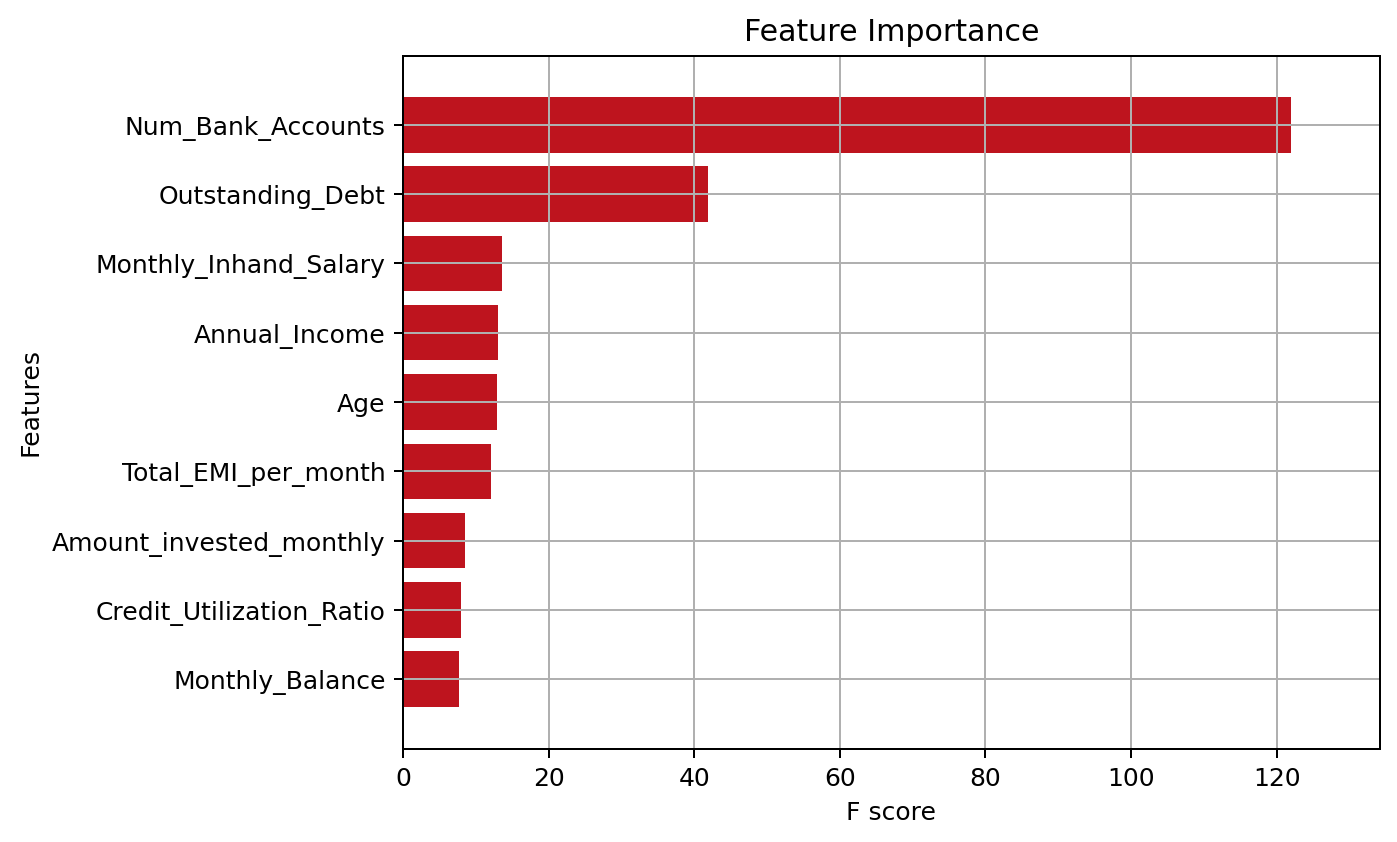

In [29]:
model.feature_names = list(map_names.values())
# plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
p = xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values=False, color='#be141e')
plt.title('Feature Importance')
plt.show()

In [30]:
##Invoking the endpoint

In [31]:
model_endpoint = xgboost_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-01-24-12-19-06-426
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-01-24-12-19-06-426
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-01-24-12-19-06-426


--------!

In [32]:
def convert_df_to_csv_object(df: pd.DataFrame) -> str:
    """Converts the dataframe object `df` to a payload that can be passed to the model endpoint.
    Args:
        df: Dataframe that is converted to a csv-file for the SageMaker model's endpoint.
    Returns:
        payload_as_csv: csv-file as payload.
    """
    assert isinstance(df, pd.DataFrame)
    csv_file = io.StringIO()
    # by default sagemaker expects comma separated
    df.to_csv(csv_file, sep=",", header=False, index=False)
    payload_as_csv = csv_file.getvalue()
    return payload_as_csv

In [33]:
def batch_prediction(payload: str, endpoint: sagemaker.predictor.Predictor) -> List[float]:
    """Function to pass a single payload to the model endpoint and return a prediction.
    Args:
        payload: SageMaker model friendly payload (feature vector).
        endpoint: SageMaker model endpoint.
    Returns:
        response: List of predictions from the model.
    """
    # invoke the endpoint to get a prediction
    response = endpoint.predict(payload, initial_args={'ContentType': "text/csv"})
    # process predictions
    response = response.decode("utf-8")
    response = [float(i) for i in response.split(',')]
    # convert to array
    response = np.asarray(response)
    return response

In [34]:
#Evaluate model (Example how the endpoint can be used)

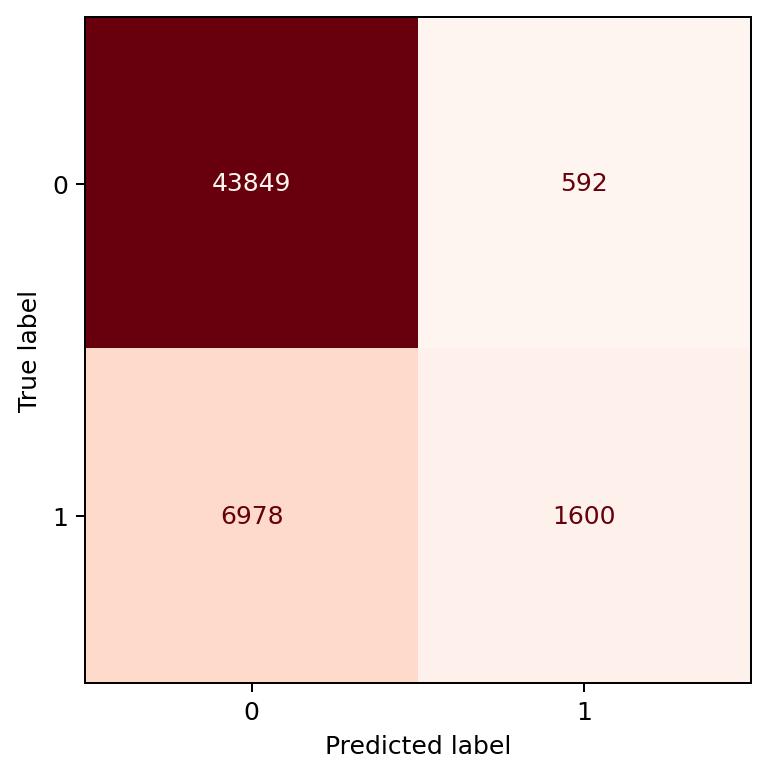

In [35]:
THRESHOLD = 0.5

train_data = pd.read_csv(TRAIN_DATA_PATH_W_HEADER)
train_features = train_data.iloc[:, 1:]

prediction = batch_prediction(
    payload=convert_df_to_csv_object(df=train_features),
    endpoint=model_endpoint
)
prediction_binary = np.where(prediction > THRESHOLD, 1, 0)

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=train_data.iloc[:, 0].values,
    y_pred=prediction_binary,
    colorbar=False,
    cmap='Reds'
)
plt.show()

In [36]:
auc = round(roc_auc_score(train_data.iloc[:, 0].values, prediction_binary), 4)
accuracy = round(accuracy_score(train_data.iloc[:, 0].values, prediction_binary), 4)
recall = round(recall_score(train_data.iloc[:, 0].values, prediction_binary), 4)
precision = round(precision_score(train_data.iloc[:, 0].values, prediction_binary), 4)
print(f'AUC is {auc}')
print(f'Accuracy is {accuracy}')
print(f'Recall is {recall}')
print(f'Precision is {precision}')

AUC is 0.5866
Accuracy is 0.8572
Recall is 0.1865
Precision is 0.7299


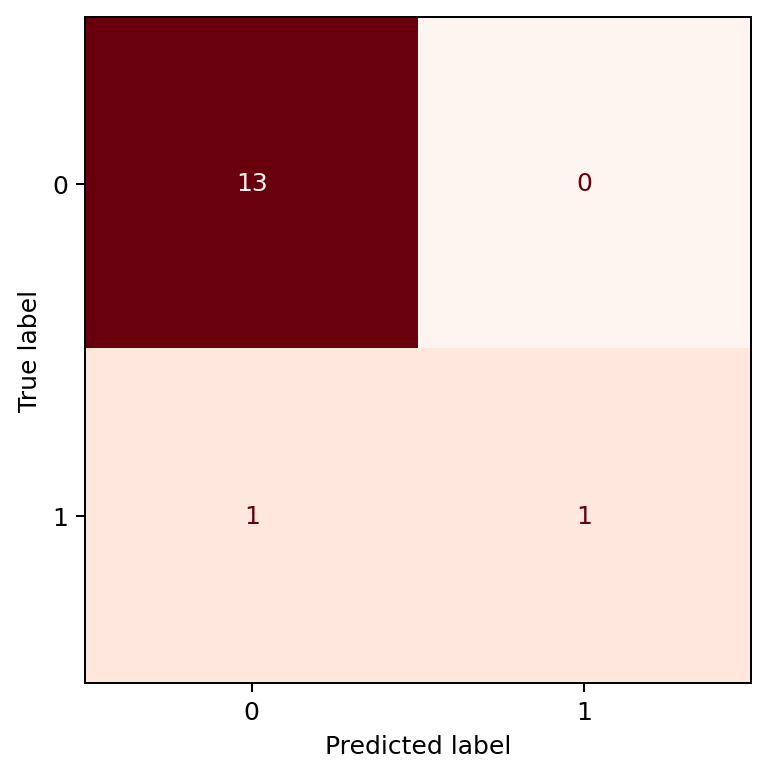

In [37]:
test_data = pd.read_csv(TEST_DATA_PATH_W_HEADER)
test_features = test_data.iloc[:, 1:]

prediction = batch_prediction(
    payload=convert_df_to_csv_object(df=test_features),
    endpoint=model_endpoint
)
prediction_binary = np.where(prediction > THRESHOLD, 1, 0)

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=test_data.iloc[:, 0].values,
    y_pred=prediction_binary,
    colorbar=False,
    cmap='Reds'
)
plt.show()

In [38]:
auc = round(roc_auc_score(test_data.iloc[:, 0].values, prediction_binary), 4)
accuracy = round(accuracy_score(test_data.iloc[:, 0].values, prediction_binary), 4)
recall = round(recall_score(test_data.iloc[:, 0].values, prediction_binary), 4)
precision = round(precision_score(test_data.iloc[:, 0].values, prediction_binary), 4)
print(f'AUC is {auc}')
print(f'Accuracy is {accuracy}')
print(f'Recall is {recall}')
print(f'Precision is {precision}')

AUC is 0.75
Accuracy is 0.9333
Recall is 0.5
Precision is 1.0


In [39]:
model_endpoint.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-01-24-12-19-06-426
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-01-24-12-19-06-426
